### Step 1: Install Required Libraries

We begin by installing the necessary Python packages. `yfinance` is used to fetch historical stock data from Yahoo Finance, `pandas` for data manipulation, and `matplotlib` for future visualizations.


In [1]:
!pip install yfinance matplotlib pandas


### Step 2: Download Tesla Stock Price Data (2015–2019)

Here, we use the `yfinance` package to download daily stock data for Tesla (ticker symbol: TSLA) from January 1, 2015, to December 31, 2019. This will serve as the foundation for our analysis of how news sentiment correlates with stock price movements.


In [11]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

# Define Tesla stock ticker and date range
ticker = "TSLA"
start_date = "2015-01-01"
end_date = "2019-12-31"

# Fetch daily stock price data
tesla_stock = yf.download(ticker, start=start_date, end=end_date)

# Preview result
tesla_stock.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


### Step 3: Check for MultiIndex Columns

After downloading the data, we print the column structure to inspect if the DataFrame has a MultiIndex. This happens occasionally with certain formats from `yfinance`, and we’ll need to flatten the index in the next step to simplify further processing.


In [13]:
print(tesla_stock.columns)


MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


In [15]:
# Flatten MultiIndex: keep just the first level (like 'Close', 'High', etc.)
tesla_stock.columns = tesla_stock.columns.get_level_values(0)

# Reset index to bring 'Date' back as a column
tesla_stock = tesla_stock.reset_index()

# Rename column if needed
tesla_stock = tesla_stock.rename(columns={"Close": "adj_close"})

tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume
0,2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
1,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
3,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
4,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [17]:
# Calculate daily returns
tesla_stock['return'] = tesla_stock['adj_close'].pct_change()

# Drop NaN from the first row
tesla_stock = tesla_stock.dropna().reset_index(drop=True)

# Preview cleaned data
tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume,return
0,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,-0.042041
1,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,0.005664
2,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,-0.001562
3,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,-0.001564
4,2015-01-09,13.777333,13.998667,13.664000,13.928000,70024500,-0.018802


### Step 4: Visualize Tesla Stock Price and Returns

Before diving into sentiment modeling, we visualize Tesla’s stock performance to understand the data’s behavior. The first plot shows the adjusted close price over time, revealing long-term trends and shifts. The second plot highlights daily percentage returns, which help detect periods of high volatility. Finally, a histogram of returns allows us to assess their distribution, an important aspect for later modeling.


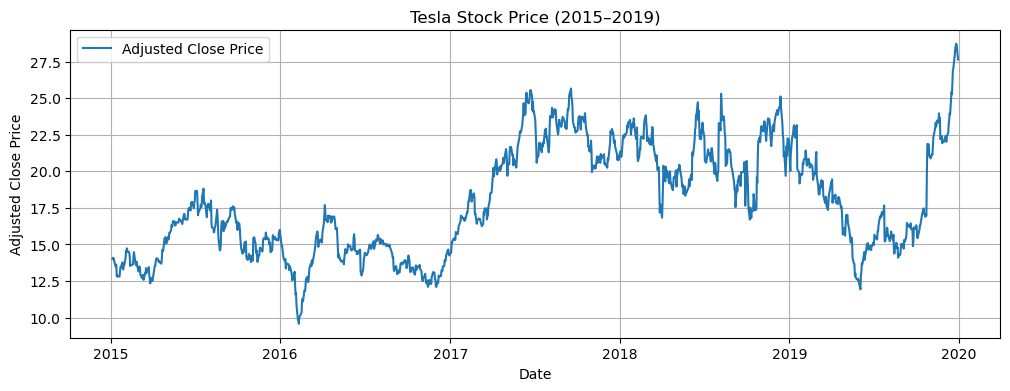

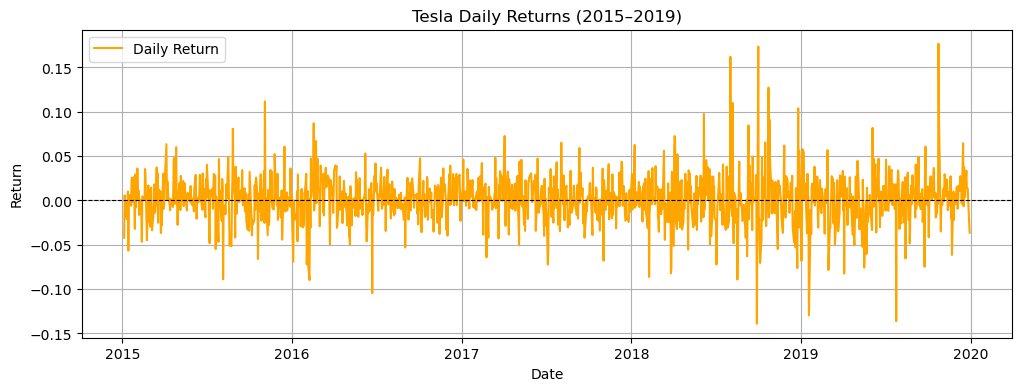

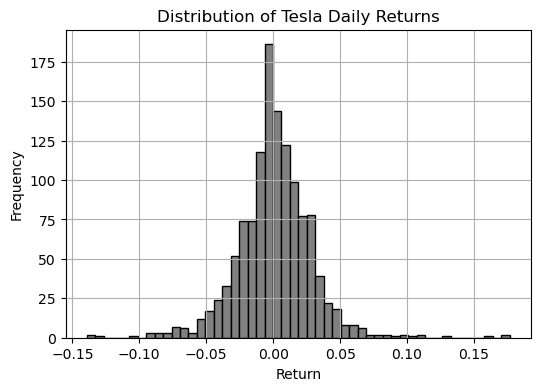

In [27]:
import matplotlib.pyplot as plt

# Plot adjusted close price
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['adj_close'], label='Adjusted Close Price')
plt.title('Tesla Stock Price (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot daily returns
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['return'], color='orange', label='Daily Return')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Tesla Daily Returns (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.show()

# Optional: histogram of returns
plt.figure(figsize=(6, 4))
plt.hist(tesla_stock['return'], bins=50, color='gray', edgecolor='black')
plt.title('Distribution of Tesla Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The plots are helpful to understand the behavior of Tesla's stock between 2015 and 2019. The adjusted close price shows a long period of relative stability followed by an abrupt spurt in late 2019, which hints at potential periods where market sentiment could have played a greater role. The plot of daily return shows consistent short-term volatility with high peaks in volatility, which are ideal for studying the impact of sentiment. Also, the return histogram exhibits a distribution about zero with small tails, which justifies the application of a normal distribution in modeling, as well as hinting at the occasional large movements. All these findings together justify the application of sentiment-based predictive modeling and motivate further investigation with Bayesian inference techniques.



### Step 5: Load and Inspect Raw Tweet Dataset

We load the full tweet dataset to examine its structure. This dataset contains tweets from multiple users between 2015 and 2019. We check the available columns to understand what information we can use, including the tweet content, time of posting, and engagement metrics like retweets and likes.


In [21]:
import pandas as pd

# Load the tweets dataset
tweets_df = pd.read_csv("/Users/chetandhingra/Downloads/Tweet.csv")  

# Preview the columns
print(tweets_df.columns)

tweets_df.head()



Index(['tweet_id', 'writer', 'post_date', 'body', 'comment_num', 'retweet_num',
       'like_num'],
      dtype='object')


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


### Step 6: Filter for Tesla-Related Tweets and Parse Dates

From the full dataset, we extract only the tweets that are relevant to Tesla by searching for keywords like "TSLA", "Tesla", or "Elon Musk". Then, we convert the UNIX timestamp (`post_date`) into a readable datetime format, which allows us to align tweets with stock data on a daily basis. We preview the cleaned subset to verify that the filtering worked correctly.


In [25]:
# Filter for Tesla-related tweets (case-insensitive)
tesla_tweets = tweets_df[
    tweets_df['body'].str.contains("TSLA|Tesla|Elon Musk", case=False, na=False)
].copy()

# Convert post_date (UNIX timestamp) to datetime
tesla_tweets['date'] = pd.to_datetime(tesla_tweets['post_date'], unit='s')

# Preview cleaned Tesla tweets
tesla_tweets[['date', 'body']].head()

,date,body
3,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...
4,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
5,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
6,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
7,2015-01-01 00:10:16,Swing Trading: Up To 8.91% Return In 14 Days h...
